# Metagenomic Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/bacterial genomes/')

# Amplicon LM

In [5]:
classification_df = pd.read_csv(path/'s16_amplicon_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
1,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Hyphomicrobiac...,train
2,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGC...,Alphaproteobacteria Sphingomonadales Sphingomo...,train
3,TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCGATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
4,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Xanthobacterac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((23545, 3), (1772, 3), (1906, 3))

In [9]:
voc = np.load(path/'bact_vocab_5m1s.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=10000, text_cols='Sequence', label_cols='Species', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.5

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.load('b1_5m1s');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


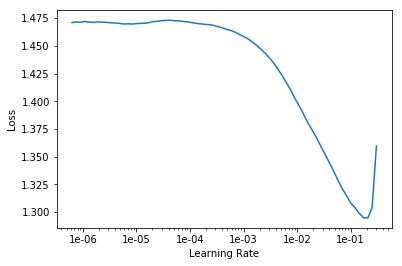

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.166149,1.003623,0.567177,00:59
1,0.952446,0.855156,0.633217,01:00
2,0.847951,0.797389,0.665496,01:00
3,0.793800,0.774159,0.679880,01:00
4,0.761029,0.758661,0.690091,01:00
5,0.740144,0.756206,0.692869,01:00
6,0.725886,0.757728,0.694427,01:00
7,0.716473,0.748832,0.698257,01:00
8,0.707582,0.754390,0.696922,01:00
9,0.698515,0.751407,0.697373,01:00


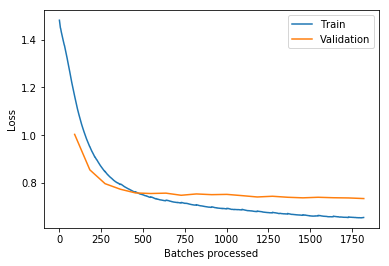

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.save('s16_amp_LM_5m1s')
learn.save_encoder('s16_amp_LM_5m1s_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'s16_amplicon_sequences.csv')

In [6]:
classification_df.head()

,Sequence,Species,set
0,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
1,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Hyphomicrobiac...,train
2,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGC...,Alphaproteobacteria Sphingomonadales Sphingomo...,train
3,TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCGATGCCGC...,Alphaproteobacteria Rhodobacterales Rhodobacte...,train
4,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,Alphaproteobacteria Rhizobiales Xanthobacterac...,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path/'bact_vocab_5m1s.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df,
                                             tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)

In [21]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.7

In [22]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [23]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.27999999999999997)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [24]:
learn.load_encoder('s16_amp_LM_5m1s_enc')
learn.freeze()

In [25]:
learn = learn.to_fp16(dynamic=True);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


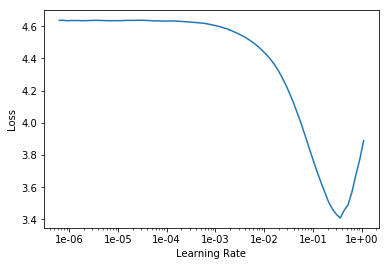

In [17]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(6, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.883913,1.453263,0.636569,00:30
1,1.333612,0.604292,0.793454,00:30
2,0.890509,0.348253,0.861174,00:30
3,0.684375,0.326238,0.880361,00:30
4,0.569416,0.274192,0.896163,00:30
5,0.504777,0.272947,0.893341,00:30


In [27]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.427863,0.227768,0.911400,00:36
1,0.344076,0.230553,0.914786,00:36
2,0.286098,0.192287,0.913093,00:36
3,0.242745,0.185775,0.914786,00:36


In [28]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.221629,0.185564,0.923815,00:55
1,0.216231,0.188858,0.918171,00:55
2,0.201700,0.166976,0.922686,00:55
3,0.187606,0.167390,0.923251,00:55


In [29]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.182277,0.164676,0.922122,01:08
1,0.175208,0.160104,0.923815,01:08
2,0.173440,0.163705,0.924379,01:08
3,0.169311,0.163452,0.923251,01:08


In [30]:
learn.save('metagenomic_amp_genus_5m1s_finetune')

In [32]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.6

In [33]:
learn = get_model_clas(data_clas, drop_mult, clas_config)
learn = learn.to_fp16(dynamic=True);

In [34]:
learn.load('metagenomic_amp_genus_5m1s_finetune');
learn.unfreeze()

In [35]:
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.151292,0.160201,0.925508,01:08
1,0.150864,0.162129,0.924379,01:08
2,0.147934,0.157796,0.926637,01:08
3,0.147528,0.158032,0.927201,01:08
4,0.143584,0.157813,0.928330,01:08
5,0.140224,0.158088,0.928330,01:08


In [36]:
learn.save('metagenomic_amp_genus_5m1s_finetune_2')

In [14]:
learn.load('metagenomic_amp_genus_5m1s_finetune_2');

In [37]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Species', bs=400)
learn.data = data_clas

In [38]:
preds = learn.get_preds()

In [39]:
p = torch.argmax(preds[0], dim=1)

In [40]:
p

tensor([17, 18, 54,  ..., 21, 42, 81])

In [41]:
(p == preds[1]).float().mean()

tensor(0.9150)

In [42]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [43]:
precision_score(preds[1], p, average='macro')

0.9309973305202565

In [44]:
recall_score(preds[1], p, average='macro')

0.9263377798959852

In [45]:
accuracy_score(preds[1], p)

0.9150052465897167

In [46]:
f1_score(preds[1], p, average='macro')

0.9230023782939568

In [47]:
pred_df = pd.DataFrame(preds[1], columns=['gt_int'])

In [48]:
pred_df['gt_name'] = pred_df.gt_int.map(lambda x: data_clas.classes[x])

In [49]:
pred_df['predicted_int'] = p
pred_df['predicted_name'] = pred_df.predicted_int.map(lambda x: data_clas.classes[x])

In [50]:
pred_df.gt_name = pred_df.gt_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [51]:
pred_df.predicted_name = pred_df.predicted_name.map(lambda x: ' '.join(x.split('_', 1)) if len(x.split()) == 3 else x)

In [52]:
taxa_list = ['Class', 'Order', 'Family', 'Genus']
for i, taxa in enumerate(taxa_list):
    print(taxa)
    print((pred_df.gt_name.map(lambda x: x.split()[i]) == pred_df.predicted_name.map(lambda x: x.split()[i])).mean())
    print('\n')

Class
1.0


Order
0.9984260230849947


Family
0.9853095487932844


Genus
0.9150052465897167


